In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import ta
from ta.momentum import RSIIndicator
from ta.trend    import MACD


In [71]:
raw = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

df  = raw.copy()

[*********************100%***********************]  1 of 1 completed


In [72]:
# 2) Create flat 1-D series for price & volume
close_s = pd.Series(df['Close'].values.flatten(), index=df.index)
vol_s   = pd.Series(df['Volume'].values.flatten(), index=df.index)

# 3) Basic features
df['Return']     = close_s.pct_change()
df['MA5']        = close_s.rolling(5).mean()
df['MA10']       = close_s.rolling(10).mean()
df['Volatility'] = df['Return'].rolling(5).std()

# 4) RSI (14-day)
df['RSI'] = RSIIndicator(close=close_s, window=14).rsi()

# 5) Bollinger Bands (20-day)
bb_w = 20
df['BB_mid']   = close_s.rolling(bb_w).mean()
df['BB_std']   = close_s.rolling(bb_w).std()
df['BB_upper'] = df['BB_mid'] + 2*df['BB_std']
df['BB_lower'] = df['BB_mid'] - 2*df['BB_std']

# 6) MACD histogram (12/26/9)
macd = MACD(close=close_s, window_fast=12, window_slow=26, window_sign=9)
df['MACD_diff'] = macd.macd_diff().values.flatten()

# 7) Manual OBV
#   – if price up, +volume; if price down, –volume; else 0. Then cumulative sum.
direction = np.sign(close_s.diff()).fillna(0)   # +1 for up, -1 for down, 0 for flat/first
df['OBV'] = (direction * vol_s).cumsum()

In [73]:
# 8) Now drop rows missing *any* feature

features = ['MA5','MA10','Volatility','RSI',
            'BB_mid','BB_std','MACD_diff','OBV']
clean = df.dropna(subset=features, how='any')



# 9) Sanity check
print("Raw rows:", len(df), "→ After drop:", len(clean))
print("Date range:", clean.index.min(), "–", clean.index.max())
clean.head()

Raw rows: 1006 → After drop: 973
Date range: 2020-02-20 00:00:00 – 2023-12-29 00:00:00


Price,Close,High,Low,Open,Volume,Return,MA5,MA10,Volatility,RSI,BB_mid,BB_std,BB_upper,BB_lower,MACD_diff,OBV
Date,,,,,,,,,,,,,,,,
2020-02-20,77.730072,78.785727,77.222874,78.295518,100566000,-0.010259,78.275629,78.277817,0.012381,53.041350,77.522871,1.346603,80.216077,74.829666,-0.107056,253844800.0
2020-02-21,75.970642,77.766472,75.351814,77.322366,129554000,-0.022635,77.701930,78.001403,0.014971,46.139474,77.457054,1.390202,80.237458,74.676650,-0.260049,124290800.0
2020-02-24,72.362045,73.818120,70.190072,72.138785,222195200,-0.047500,76.402632,77.471150,0.022362,35.838957,77.221943,1.797950,80.817842,73.626043,-0.580687,-97904400.0
2020-02-25,69.910973,73.417688,69.437753,73.034258,230673600,-0.033872,74.901903,76.658904,0.023662,30.807982,76.977583,2.381963,81.741509,72.213657,-0.914399,-328578000.0
2020-02-26,71.020027,72.289241,69.527552,69.534832,198054800,0.015864,73.398752,76.004642,0.024167,35.237933,76.682876,2.729494,82.141864,71.223888,-1.009528,-130523200.0


In [74]:
# Split into training and test sets
X = df[features]

# Target: 1 if next day's return > 0, else 0
y = (df['Return'].shift(-1) > 0).astype(int)
y = y.loc[X.index]  # Align indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [75]:
# Train Random Forest
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=10, n_estimators=200, random_state=42)

In [76]:
# ── Robust Threshold Sweep ──

probs = model.predict_proba(X_test)[:,1]
rets  = clean.loc[X_test.index, 'Return']



results = []
for thresh in np.linspace(0.1, 0.9, 17):
    sig        = (probs > thresh).astype(int)
    strat_ret  = rets * sig
    n_trades   = sig.sum()
    ret_mean   = strat_ret.mean()
    ret_std    = strat_ret.std()
    
    # Skip if no trades or zero volatility
    if n_trades == 0 or ret_std == 0 or np.isnan(ret_std):
        continue
    
    sharpe = ret_mean / ret_std * np.sqrt(252)
    results.append((thresh, sharpe, n_trades))

# If results is empty, no valid threshold—lower your start threshold
if not results:
    raise ValueError("No valid thresholds (all produced zero-volatility returns). "
                     "Try expanding threshold range or using a smaller lower bound.")

# Pick the best by Sharpe
best_thresh, best_sharpe, num_trades = max(results, key=lambda x: x[1])

# Show the full table

df_thresh = pd.DataFrame(results, columns=['threshold','sharpe','n_trades'])
print(df_thresh)

print(f"\n→ Best threshold = {best_thresh:.2f}, Sharpe = {best_sharpe:.2f}, Trades = {num_trades}")


    threshold    sharpe  n_trades
0        0.10  1.152141       302
1        0.15  1.152141       302
2        0.20  1.152141       302
3        0.25  1.152141       302
4        0.30  1.146967       298
5        0.35  0.586899       249
6        0.40  0.421720       190
7        0.45  0.337154       138
8        0.50  0.629304        92
9        0.55  0.339427        67
10       0.60  0.120190        31
11       0.65 -1.379740        12
12       0.70 -2.074940         7
13       0.75 -1.500124         4
14       0.80 -1.313639         3

→ Best threshold = 0.10, Sharpe = 1.15, Trades = 302


In [77]:
# ── Evaluate Exposure & Sharpe Across Thresholds ──

probs = model.predict_proba(X_test)[:,1]
rets  = clean.loc[X_test.index, 'Return']
n_days = len(rets)

import numpy as np
import pandas as pd

rows = []
for thresh in np.linspace(0.1, 0.9, 17):
    sig       = (probs > thresh).astype(int)
    n_in_mkt  = sig.sum()
    exp_pct   = n_in_mkt / n_days * 100
    strat_ret = rets * sig
    if strat_ret.std() == 0: 
        sharpe = np.nan
    else:
        sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
    rows.append((thresh, exp_pct, sharpe, n_in_mkt))

df_thresh = pd.DataFrame(rows, columns=['threshold','in_market_%','sharpe','n_trades'])
display(df_thresh)

# Pick a candidate threshold where in_market_% ~ 60–80% and sharpe is high
candidates = df_thresh[(df_thresh['in_market_%'] >= 60) & 
                       (df_thresh['in_market_%'] <= 80)].sort_values('sharpe', ascending=False)
print("\nBest in 60–80% exposure:\n", candidates.head(3))


,threshold,in_market_%,sharpe,n_trades
0,0.10,100.000000,1.152141,302
1,0.15,100.000000,1.152141,302
2,0.20,100.000000,1.152141,302
3,0.25,100.000000,1.152141,302
4,0.30,98.675497,1.146967,298
5,0.35,82.450331,0.586899,249
6,0.40,62.913907,0.421720,190
7,0.45,45.695364,0.337154,138
8,0.50,30.463576,0.629304,92
9,0.55,22.185430,0.339427,67



Best in 60–80% exposure:
    threshold  in_market_%   sharpe  n_trades
6        0.4    62.913907  0.42172       190


In [78]:
# Predict
predictions = model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

for name, imp in zip(features, model.feature_importances_):
    print(f"{name:12s} → {imp:.4f}")





Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.71      0.57       140
           1       0.57      0.32      0.41       162

    accuracy                           0.50       302
   macro avg       0.52      0.52      0.49       302
weighted avg       0.52      0.50      0.48       302

Confusion Matrix:
[[100  40]
 [110  52]]
MA5          → 0.1086
MA10         → 0.1218
Volatility   → 0.1319
RSI          → 0.1240
BB_mid       → 0.0986
BB_std       → 0.1503
MACD_diff    → 0.1225
OBV          → 0.1424


In [79]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators':    [100, 200],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 5, 10]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',       # or 'precision' on the up-class
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
model = grid.best_estimator_

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


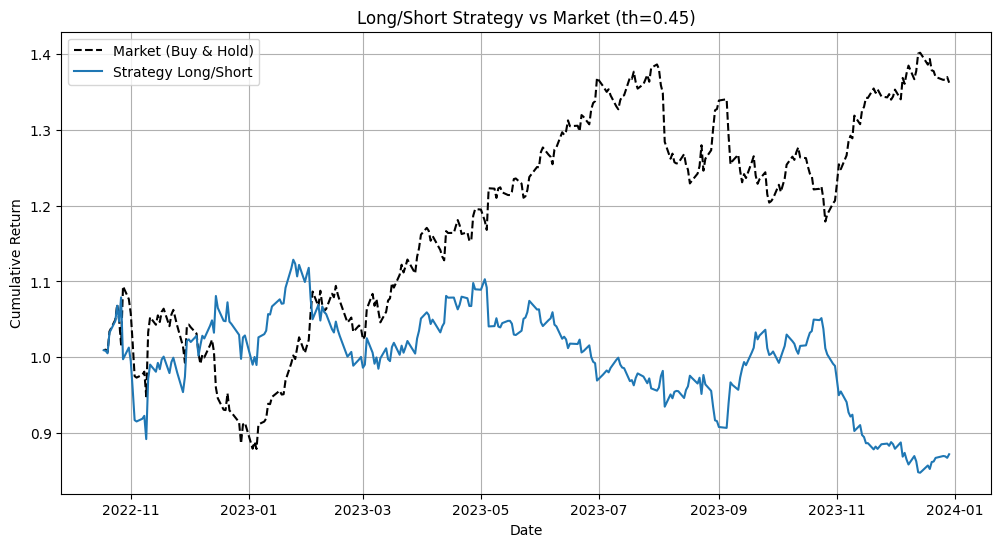

In market (long or short): 100.0% of days
Final cumulative: Strategy_LS=0.87, Market=1.36


In [80]:
# ── Long/Short Backtest with Optimal Threshold ──

import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare
thresh_sel = 0.42  # from your threshold sweep, e.g. 0.50
rets = clean.loc[X_test.index, 'Return']
probs = model.predict_proba(X_test)[:,1]

# 2) Build signals DataFrame
signals = pd.DataFrame(index=X_test.index)
signals['Prob_up'] = probs

# Long/Short position:
#  +1 if prob > thresh_sel
#  -1 if prob < (1 - thresh_sel)
#   0 otherwise
signals['Position'] = np.where(
    signals['Prob_up'] > thresh_sel,  1,
    np.where(signals['Prob_up'] < (1 - thresh_sel), -1, 0)
)

# 3) Compute strategy returns
signals['Strat_Ret_LS'] = rets * signals['Position']
signals['Cum_Strategy_LS'] = (1 + signals['Strat_Ret_LS']).cumprod()

# 4) Compute buy-and-hold for comparison
signals['Cum_Market'] = (1 + rets).cumprod()

# 5) Plot
plt.figure(figsize=(12,6))
plt.plot(signals['Cum_Market'],         label='Market (Buy & Hold)', linestyle='--', color='k')
plt.plot(signals['Cum_Strategy_LS'],    label='Strategy Long/Short')
plt.title(f'Long/Short Strategy vs Market (th={thresh_sel:.2f})')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# 6) Print exposure and final returns
exp_pct = (signals['Position'] != 0).mean() * 100
final_ls = signals['Cum_Strategy_LS'].iloc[-1]
final_mk = signals['Cum_Market'].iloc[-1]
print(f"In market (long or short): {exp_pct:.1f}% of days")
print(f"Final cumulative: Strategy_LS={final_ls:.2f}, Market={final_mk:.2f}")


Thresh 0.37: in market 67.9% of days
Thresh 0.40: in market 57.9% of days
Thresh 0.45: in market 42.1% of days
Thresh 0.50: in market 29.1% of days
Thresh 0.70: in market 4.3% of days


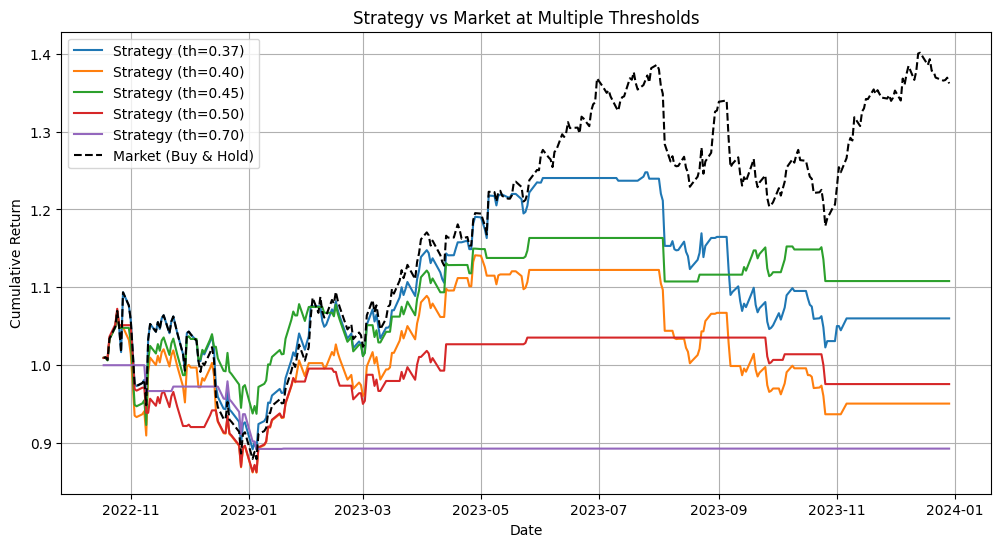

In [81]:
# 1) Reference market cumulative returns
cum_mkt = (1 + clean.loc[X_test.index, 'Return']).cumprod()

# 2) Choose thresholds to compare
thresholds = [0.37, 0.40, 0.45, 0.50, 0.70]

plt.figure(figsize=(12,6))

for th in thresholds:
    # build signal for this threshold
    sig = (probs > th).astype(int)
    strat_ret = clean.loc[X_test.index, 'Return'] * sig
    
    # optional: print exposure
    exposure = sig.mean() * 100
    print(f"Thresh {th:.2f}: in market {exposure:.1f}% of days")
    
    # cum-returns for this strategy
    cum_strat = (1 + strat_ret).cumprod()
    
    # plot it
    plt.plot(cum_strat, label=f'Strategy (th={th:.2f})')

# 3) Plot buy-and-hold last so it’s in the background
plt.plot(cum_mkt, color='k', linestyle='--', label='Market (Buy & Hold)')

plt.title('Strategy vs Market at Multiple Thresholds')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Strategy is long 29.1% of days


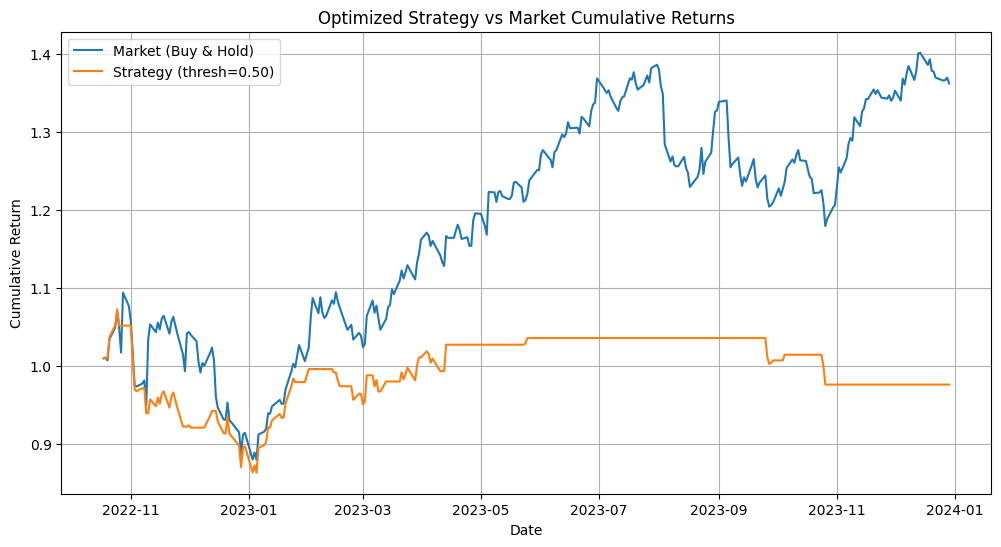

Final cumulative: Strategy=0.98, Market=1.36


In [82]:
# ── Backtest with Optimal Threshold ──

# 1) Use the threshold from the sweep
thresh = 0.5

# 2) Build signals and returns
signals = pd.DataFrame(index=X_test.index)
signals['Prob_up']        = probs
signals['Signal']         = (signals['Prob_up'] > thresh).astype(int)
signals['Actual_Return']  = clean.loc[X_test.index, 'Return']
signals['Strategy_Return'] = signals['Actual_Return'] * signals['Signal']

 # What fraction of days does the model go long?
in_market_pct = signals['Signal'].mean() * 100
print(f"Strategy is long {in_market_pct:.1f}% of days")


# 3) Cumulative returns
signals['Cum_Strategy'] = (1 + signals['Strategy_Return']).cumprod()
signals['Cum_Market']   = (1 + signals['Actual_Return']).cumprod()

# 4) Plot
plt.figure(figsize=(12,6))
plt.plot(signals['Cum_Market'],   label='Market (Buy & Hold)')
plt.plot(signals['Cum_Strategy'], label=f'Strategy (thresh={thresh:.2f})')

plt.title('Optimized Strategy vs Market Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# 5) Print final stats
final_strat = signals['Cum_Strategy'].iloc[-1]
final_mkt   = signals['Cum_Market'].iloc[-1]
print(f"Final cumulative: Strategy={final_strat:.2f}, Market={final_mkt:.2f}")


In [64]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(signals['Cumulative_Strategy_Returns'], label='Strategy')
plt.plot(signals['Cumulative_Market_Returns'], label='Market (Buy & Hold)')
plt.title('Strategy vs Market Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


KeyError: 'Cumulative_Strategy_Returns'

<Figure size 1200x600 with 0 Axes>

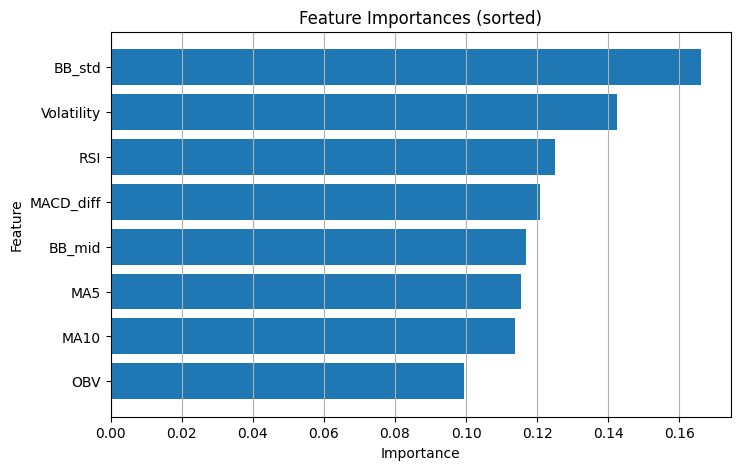

In [65]:
# Plot Feature Importances
# 1) Extract importances as a plain list of floats
importances = model.feature_importances_.tolist()

# 2) Get feature names as a plain list of strings
feature_names = list(X.columns)

# 3) Build a sorted index (from least to most important)
sorted_idx = sorted(range(len(importances)), key=lambda i: importances[i])

# 4) Reorder names & importances using that index
sorted_features    = [feature_names[i]   for i in sorted_idx]
sorted_importances = [importances[i]     for i in sorted_idx]

y_pos = np.arange(len(sorted_importances))

# 2) Plot horizontal bars at those positions
plt.figure(figsize=(8,5))
plt.barh(y_pos, sorted_importances, align='center')

# 3) Replace y-tick labels with your feature names
plt.yticks(y_pos, sorted_features)

# 4) Labels and grid
plt.title('Feature Importances (sorted)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.show()


In [67]:
# Create signals
signals = pd.DataFrame(index=X_test.index)
signals['Predicted_Signal'] = predictions
signals['Actual_Return'] = df.loc[X_test.index]['Return']

# Strategy return: only get return if predicted "up"
signals['Strategy_Return'] = signals['Actual_Return'] * signals['Predicted_Signal']

# Cumulative returns
signals['Cumulative_Strategy_Returns'] = (1 + signals['Strategy_Return']).cumprod()
signals['Cumulative_Market_Returns'] = (1 + signals['Actual_Return']).cumprod()

signals.head()

sharpe = signals['Strategy_Return'].mean() / signals['Strategy_Return'].std() * np.sqrt(252)
print(f"Sharpe is {sharpe}")



Sharpe is 1.125338548757022
